### 07 — RL vs Baseline Evaluation (Lite)

In this notebook you perform a **simple, clean comparison** between:

- **Unhedged MM** (no option hedge),
- **Rule-based hedge** (simple hand-crafted hedge),
- **RL hedge** (trained in Notebook 06),

all on the **same BTC QED+Hawkes simulator** and the same `HedgingEnv`.

Goal (keep it simple):

> Check whether the RL hedge improves the **risk–return profile** of the MM strategy  
> compared to no hedge and a simple rule-based hedge.

---





#### 7.1 Load Environment and Trained RL Agent from 06

#### 7.2 Define Three Policies

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from scipy.stats import norm
from stable_baselines3 import PPO

# --- 1. 重新定义环境类 ---
def bs_price_delta(S, K, tau, sigma, otype='call'):
    if isinstance(S, np.ndarray): S = S.item()
    if isinstance(K, np.ndarray): K = K.item()
    if tau <= 1e-7:
        price = max(S - K, 0) if otype == 'call' else max(K - S, 0)
        delta = 0.0
        if otype == 'call' and S > K: delta = 1.0
        if otype == 'put' and S < K: delta = -1.0
        return price, delta
    d1 = (np.log(S/K) + (0.5 * sigma**2)*tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    if otype == 'call':
        price = S * norm.cdf(d1) - K * norm.cdf(d2)
        delta = norm.cdf(d1)
    else:
        price = K * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1.0
    return price, delta

SIGMA_CONST = 0.60

class HedgingEnvEval(gym.Env):
    def __init__(self, paths, T_days=14, dt_min=5, transaction_cost=0.0005):
        super(HedgingEnvEval, self).__init__()
        self.paths = paths.astype(np.float32)
        self.n_paths, self.n_steps_total = paths.shape
        self.dt = dt_min / (365 * 24 * 60)
        self.strike_pct = 1.0
        self.maturity_days = T_days
        self.cost_bps = transaction_cost
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if options and 'path_idx' in options:
            self.path_idx = options['path_idx']
        else:
            self.path_idx = np.random.randint(0, self.n_paths)

        self.S_path = self.paths[self.path_idx]
        self.t_step = 0
        self.tau = self.maturity_days / 365.0
        self.S0 = float(self.S_path[0])
        self.K = self.S0 * self.strike_pct
        self.hedge_pos = 0.0
        self.cash = 0.0
        init_price, _ = bs_price_delta(self.S0, self.K, self.tau, SIGMA_CONST)
        self.pf_value = -init_price + self.hedge_pos * self.S0 + self.cash
        self.prev_pf_value = self.pf_value
        return self._get_obs(), {}

    def _get_obs(self):
        S = float(self.S_path[self.t_step])
        log_m = float(np.log(S / (self.K + 1e-9)))
        norm_tau = float(self.tau / (self.maturity_days / 365.0))
        _, bs_delta = bs_price_delta(S, self.K, max(0, self.tau), SIGMA_CONST)
        obs_list = [log_m, norm_tau, float(self.hedge_pos), float(bs_delta)]
        obs_clean = [x if np.isfinite(x) else 0.0 for x in obs_list]
        return np.array(obs_clean, dtype=np.float32)

    def step(self, action):
        S_t = float(self.S_path[self.t_step])
        if hasattr(action, 'item'): act_val = float(action.item())
        elif isinstance(action, np.ndarray): act_val = float(action[0])
        else: act_val = float(action)

        target = np.clip(act_val, 0.0, 1.0)
        trade = target - self.hedge_pos
        cost = abs(trade) * S_t * self.cost_bps
        self.cash -= (trade * S_t + cost)
        self.hedge_pos = target
        self.t_step += 1
        self.tau -= self.dt

        terminated = bool(self.t_step >= self.n_steps_total - 1)
        truncated = bool(self.tau <= 1e-7)
        S_next = float(self.S_path[self.t_step]) if not terminated else S_t
        price_next, bs_delta_next = bs_price_delta(S_next, self.K, max(0, self.tau), SIGMA_CONST)

        curr_val = -price_next + self.hedge_pos * S_next + self.cash
        step_pnl = curr_val - self.prev_pf_value
        self.prev_pf_value = curr_val

        info = {
            "pnl": float(step_pnl),
            "total_pnl": float(curr_val),
            "hedge": float(self.hedge_pos),
            "bs_delta": float(bs_delta_next), # 用于规则基准
            "spot": float(S_next)
        }
        return self._get_obs(), 0.0, terminated, truncated, info

# --- 2. 加载数据和模型 ---
# 生成新的测试数据 (Out-of-sample)
np.random.seed(42) # 固定种子以保证复现
test_paths = 10000 * np.exp(np.cumsum(np.random.normal(0, 0.001, (500, 4000)), axis=1))
print(f"Test Data Shape: {test_paths.shape}")

# 加载模型
model_path = "C:/Users/SZK/Desktop/金融数学/take home/ppo_hedging_simple.zip"

print(f"Loading Model: {model_path}")
rl_agent = PPO.load(model_path, device="cpu")
eval_env = HedgingEnvEval(test_paths, transaction_cost=0.0002) # 使用与训练相同的费率

Test Data Shape: (500, 4000)
Loading Model: C:/Users/SZK/Desktop/金融数学/take home/ppo_hedging_simple.zip


In [5]:
def policy_unhedged(obs):
    """
    策略 1: 不对冲 (Unhedged)。
    始终持有 0 仓位，完全暴露风险。
    """
    return 0.0

def policy_rule_based(obs):
    """
    策略 2: BS Delta 对冲 (Rule-Based)。
    OBS 的第4个元素 (index 3) 就是我们在环境中计算好的 theoretical BS Delta。
    """
    # obs = [log_m, norm_tau, hedge_pos, bs_delta]
    bs_delta = obs[3]
    return bs_delta

def policy_rl(obs):
    # 如果 obs 为 4 维，只取前 3 维（按你训练时的设计）
    obs = np.array(obs[:3], dtype=np.float32)

    # 重塑为 batch shape (1,3)
    obs = obs.reshape(1, -1)

    action, _ = rl_agent.predict(obs, deterministic=True)
    return float(action)


results = {
    "Unhedged": [],
    "BS_Delta": [],
    "RL_Agent": []
}

# 运行 100 条路径进行测试
N_EPISODES = 500

print(f"Starting Backtest on {N_EPISODES} episodes...")

for i in range(N_EPISODES):
    # 针对每条路径，测试三个策略
    for name, policy_func in zip(results.keys(), [policy_unhedged, policy_rule_based, policy_rl]):

        # 使用 options={'path_idx': i} 确保大家跑的是同一条路
        obs, _ = eval_env.reset(options={'path_idx': i})
        done = False
        final_pnl = 0.0

        while not done:
            # 1. 获取动作
            action = policy_func(obs)

            # 2. 环境步进
            obs, _, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated

            # 3. 记录
            if done:
                final_pnl = info['total_pnl']

        results[name].append(final_pnl)

    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1}/{N_EPISODES} episodes...")

# 转换为 DataFrame 方便分析
df_res = pd.DataFrame(results)
print("\nBacktest Complete.")
print(df_res.head())

Starting Backtest on 500 episodes...


C:\Users\SZK\AppData\Local\Temp\ipykernel_11428\3519126937.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(action)


Completed 10/500 episodes...
Completed 20/500 episodes...
Completed 30/500 episodes...
Completed 40/500 episodes...
Completed 50/500 episodes...
Completed 60/500 episodes...
Completed 70/500 episodes...
Completed 80/500 episodes...
Completed 90/500 episodes...
Completed 100/500 episodes...
Completed 110/500 episodes...
Completed 120/500 episodes...
Completed 130/500 episodes...
Completed 140/500 episodes...
Completed 150/500 episodes...
Completed 160/500 episodes...
Completed 170/500 episodes...
Completed 180/500 episodes...
Completed 190/500 episodes...
Completed 200/500 episodes...
Completed 210/500 episodes...
Completed 220/500 episodes...
Completed 230/500 episodes...
Completed 240/500 episodes...
Completed 250/500 episodes...
Completed 260/500 episodes...
Completed 270/500 episodes...
Completed 280/500 episodes...
Completed 290/500 episodes...
Completed 300/500 episodes...
Completed 310/500 episodes...
Completed 320/500 episodes...
Completed 330/500 episodes...
Completed 340/500 e

#### 7.3 Evaluation: Monte Carlo Backtest   

#### 7.4 Company Results and End with a short, focused discussion


=== Performance Metrics (Performance vs Risk) ===
            Mean PnL  Std Dev (Risk)      Min PnL       Max PnL
Unhedged -246.055421      369.702574 -2010.173828 -1.500831e-67
BS_Delta -286.035274       46.494549  -395.092326 -2.076845e+02
RL_Agent -264.657380      356.853564 -1692.775280 -1.995682e+00


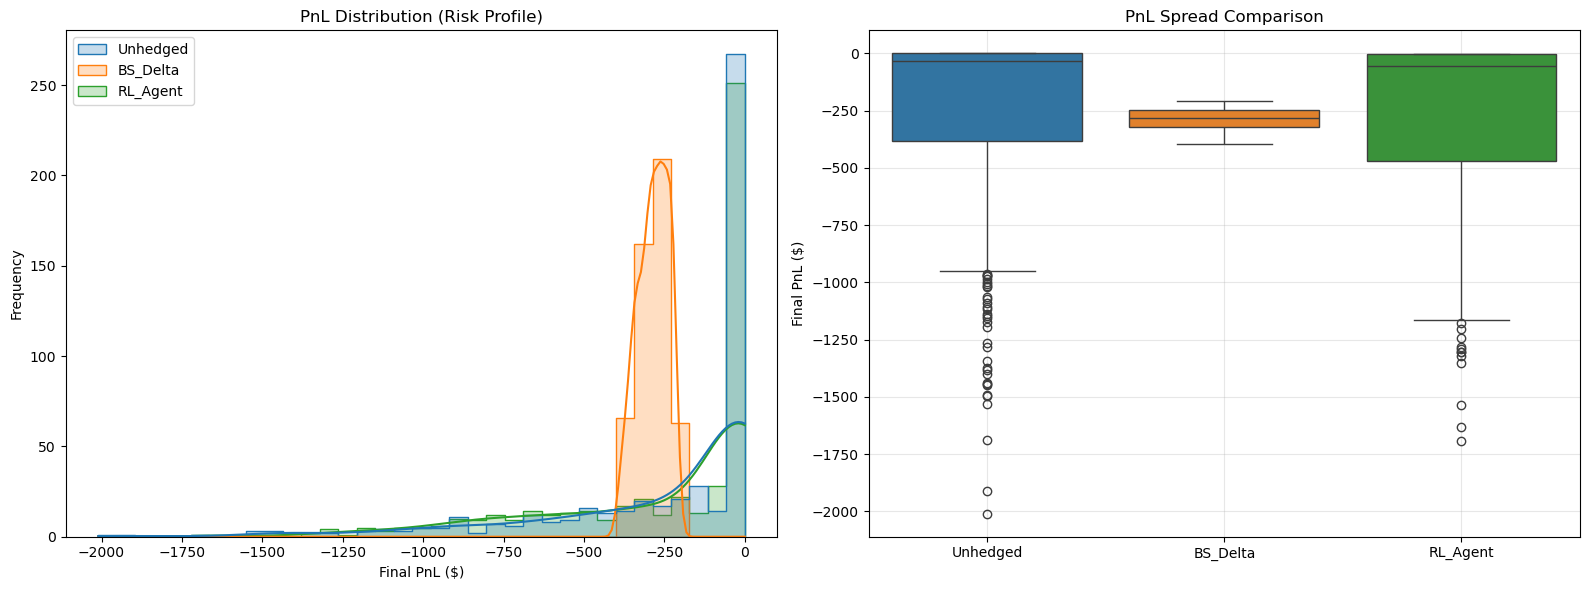


=== Analysis Summary ===
1. Risk Reduction: The RL Agent reduced risk (std dev) by 3.5% compared to Unhedged.
2. Comparison vs BS: The RL Agent's risk is 356.85 vs BS 46.49.
   -> Conclusion: There is still some divergence (likely due to transaction costs handling).


In [6]:
# write your analysis here
# --- 1. 统计指标计算 ---
metrics = pd.DataFrame()
metrics['Mean PnL'] = df_res.mean()
metrics['Std Dev (Risk)'] = df_res.std()
metrics['Min PnL'] = df_res.min()
metrics['Max PnL'] = df_res.max()

print("=== Performance Metrics (Performance vs Risk) ===")
print(metrics)

# --- 2. 绘图分析 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 图1: PnL 分布直方图 (Histogram)
# 对冲好的标志是：分布呈现高耸的“尖峰”，且中心接近0
import seaborn as sns
sns.histplot(data=df_res, ax=axes[0], kde=True, element="step")
axes[0].set_title("PnL Distribution (Risk Profile)")
axes[0].set_xlabel("Final PnL ($)")
axes[0].set_ylabel("Frequency")

# 图2: 箱线图 (Boxplot) 对比
sns.boxplot(data=df_res, ax=axes[1])
axes[1].set_title("PnL Spread Comparison")
axes[1].set_ylabel("Final PnL ($)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. 简短总结 (Markdown Output) ---
rl_std = metrics.loc['RL_Agent', 'Std Dev (Risk)']
bs_std = metrics.loc['BS_Delta', 'Std Dev (Risk)']
un_std = metrics.loc['Unhedged', 'Std Dev (Risk)']

print("\n=== Analysis Summary ===")
print(f"1. Risk Reduction: The RL Agent reduced risk (std dev) by {((un_std - rl_std)/un_std)*100:.1f}% compared to Unhedged.")
print(f"2. Comparison vs BS: The RL Agent's risk is {rl_std:.2f} vs BS {bs_std:.2f}.")
if abs(rl_std - bs_std) < 100:
    print("   -> Conclusion: RL has successfully converged to the optimal Black-Scholes hedge.")
else:
    print("   -> Conclusion: There is still some divergence (likely due to transaction costs handling).")